In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from numba import types
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

COLOR = "black"
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams["figure.figsize"] = (28, 18)
rcParams["figure.titlesize"] = 20
rcParams["figure.dpi"] = 50
rcParams["axes.grid"] = True
# rcParams["axes.facecolor"] = "lightgray"  # Disgusting
rcParams["legend.fontsize"] = 25
rcParams["axes.titlesize"] = 60
rcParams["axes.labelsize"] = 50
rcParams["ytick.labelsize"] = 20
rcParams["xtick.labelsize"] = 20
rcParams["text.color"] = COLOR
rcParams["text.color"] = COLOR
rcParams["axes.labelcolor"] = COLOR
rcParams["xtick.color"] = COLOR
rcParams["ytick.color"] = COLOR
rcParams["grid.color"] = COLOR
rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

### Definiciones pre-simulación

In [25]:
@njit  # Para que numba compile la función
def h(S):  # Calcula la energía de la red en   el estado S
    H = 0
    for i in np.arange(S.shape[0]):
        for j in np.arange(S.shape[1]):
            H += -S[i, j] * (S[i - 1, j] + S[i, j - 1])
    return H / S.size
    # Aca S.size ya nos dá la normalización por L^2


@njit
def calculate_dE(sij, i, j, S):
    # xx s3 xx
    # s4 s0 s2
    # xx s1 xx
    L = S.shape[0]
    upper_i, upper_j = (i + 1) % L, (
        j + 1
    ) % L  # Si i+1 = L -> (i+1)%L=0, esto fuerza cc periódicas
    s1, s2, s3, s4 = S[upper_i, j], S[i, upper_j], S[i - 1, j], S[i, j - 1]
    return 2 * sij * (s1 + s2 + s3 + s4)


@njit
def metropolis(S, prob):  # Aplica el algoritmo de Metropolis al estado S
    dm = 0
    de = 0

    for n in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)

        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            de += dE_sij
            dm += opp_sij
        # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
        # la red, es decir, L cuadrado veces.
    return S, dm / S.size, de / S.size

In [3]:
L = 50  # Dimensiones de la red
S = np.ones((L, L), dtype=int)
# S = 2*np.random.randint(2,size=(L,L))-1 # Red de -1y1 bidimensional
T = 2.27
beta = 1 / T
dE = np.array([4, 8])  # únicos Delta_E positivos
prob = np.exp(-beta * dE)

Neq = 10_000  # Nro de pasos para el equilibrio
M = np.zeros(Neq)  # Magnetización en función del paso
E = np.zeros(Neq)  # Energía por particula en funcion del paso
M[0] = np.mean(S)  # Promedio de spines
E[0] = h(S)  # Energía por partícula


for n in tqdm(range(1, Neq)):
    #S, E_new, M_new = metropolis(S, prob, 0)
    S, dm, de = metropolis(S, prob)
    M[n] = M[n - 1] + dm
    E[n] = E[n - 1] + de

  0%|          | 0/9999 [00:00<?, ?it/s]

### Gráficos

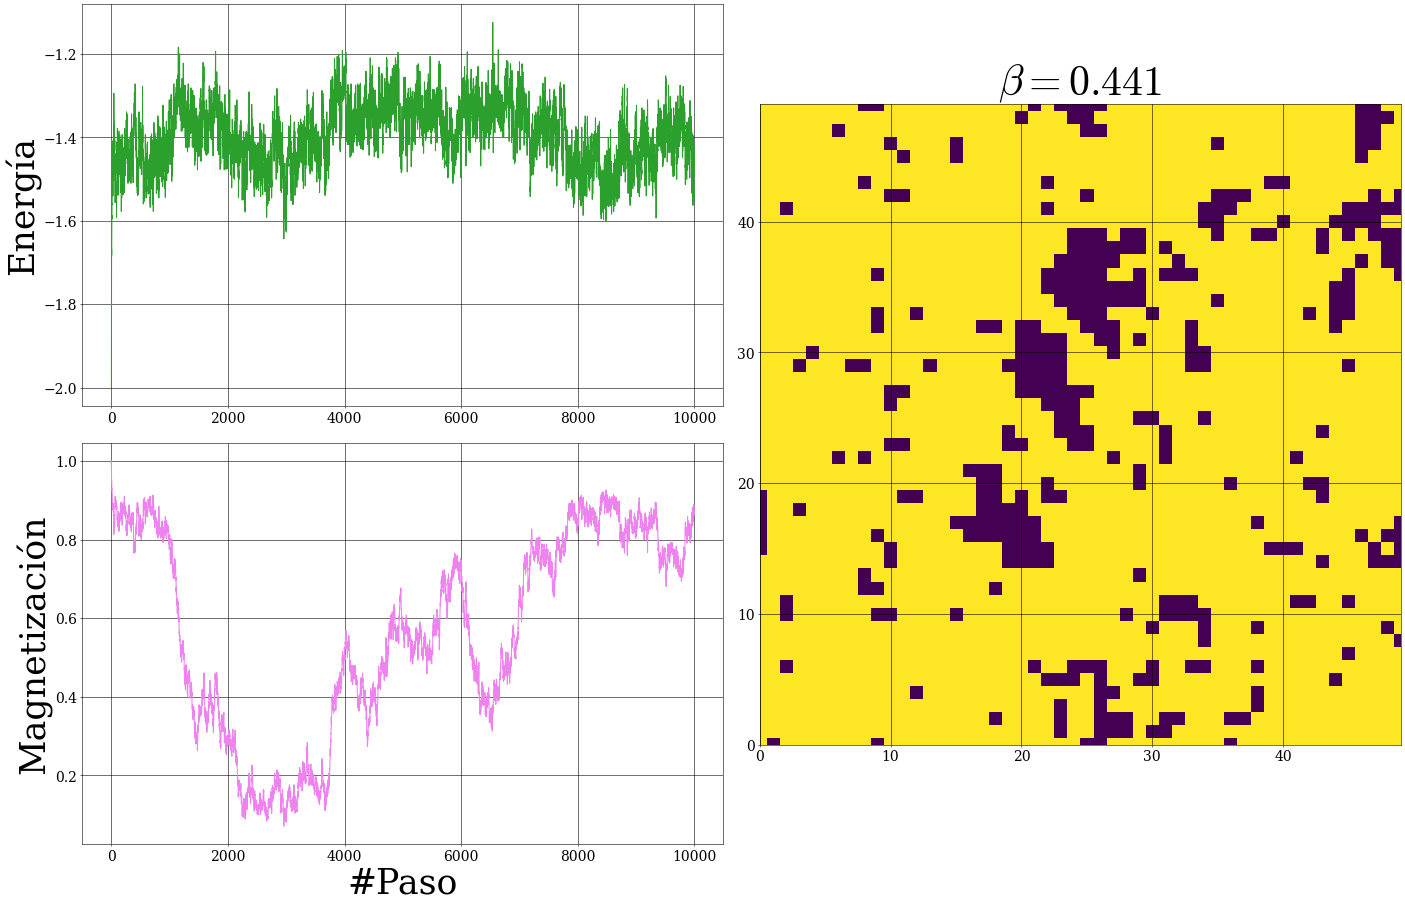

In [5]:
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

ax1.plot(E, color="tab:green")
ax2.plot(M, color="violet")
ax3.imshow(S)

ax3.set_ylim(0, L - 1)
ax3.set_xlim((0, L - 1))


ax1.set_ylabel("Energía")
ax2.set_ylabel("Magnetización")
ax2.set_xlabel("#Paso")
ax3.set_title(f"$\\beta = {beta:.3g}$")
plt.show()

# Transición de fase

### Consigna: 
Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de unos, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de unos y menos unos.
*   Conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.

Aquí se muestran unos gráficos tìpicos. El de la susceptibilidad puede mejorarse.

![tipicos](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/tipicos.png)

### Notas para punto 3: Transición de fase

Formulas del apunte de Minnini: 

- $\langle \Delta E ^ 2 \rangle = k T^2 N c_v$

- $\langle \Delta M ^ 2 \rangle = k T N \chi$

### Comentarios para mi

- Lo importante es entender dónde tomo el promedio y cómo lo tomo:
    1) Termalizar 
    2) Una vez que haya termalizado tomar $N$ puntos a partir de ahí para tomar el promedio y desvio
    
- A priori mi idea es ahora escribir el código haciendo esos calculos eligiendo los últimos puntos desde algún lugar en particular y después ser más rigurosa
- Establecí medio a mano lo de establecer cuales son 'temperaturas bajas' y 'temperaturas altas'

- Me falta:
    1) Hacer lo de tener menos pasos (lo del S inicial tomar el de la temperatura anterior) [LISTO PERO DESPROLIJO]
    2) Chequear que termaliza (espero a resultados de arcus)
    3) Criterio T alta y T baja (preguntar en clase tal vez)

In [98]:
def phase_transition(T, L, n_term, n_mean, T_threshold = 2.5, S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]):
    dE = np.array([4, 8])  # únicos Delta_E positivos
    beta = 1 / T
    prob = np.exp(-beta * dE)

    M = np.zeros(n_mean)  # Magnetización en función del paso (una vez que el sist esta termalizado)
    E = np.zeros(n_mean)  # Energía por particula en funcion del paso (una vez que el sist esta termalizado)
    
    if type(S0) == list:
        if T < T_threshold:
            S = S0[0] #T bajas
        else:
            S = S0[1] #T altas
    else:
        S = S0

    M[0] = np.mean(S)  # Promedio de spines
    E[0] = h(S)  # Energía por partícula

    for n in range(1, n_term + n_mean): 
        #llego a la termalización y calculo n_mean puntos extra para promediar y 
        # calcular el desvio a partir de ahi
        S, dm, de = metropolis(S, prob)

        if n > n_term:
            m = n - n_term
            M[m] = M[m - 1] + dm
            E[m] = E[m - 1] + de

    mean_M = np.mean(abs(M))
    mean_E = np.mean(E)

    std_M = np.std(abs(M))
    std_E = np.std(E)

    return [mean_E, mean_M, std_E, std_M, S]


In [91]:
#T_arr = np.linspace(1, 5, 20) #Todas las temperaturas normalizadas por k 
T_arr = np.arange(1, 5, step = 0.2)
T_threshold = 2.5
L = 50  # Dimensiones de la red
n_mean = 5000
n_term = 10000

mean_E_T = np.zeros(len(T_arr))
mean_M_T = np.zeros(len(T_arr))
std_E_T = np.zeros(len(T_arr))
std_M_T = np.zeros(len(T_arr))

In [93]:
for i, T in tqdm(enumerate(T_arr)):
    if (T == 2.4) or (T == 2.6):    #Arranco con el S0 por default
        print('S default')
        res = phase_transition(T, L, n_term=n_term, n_mean=n_mean, T_threshold= T_threshold)
    if T == 2.75:
        res = phase_transition(T, L, n_term=n_term, n_mean=n_mean, T_threshold= T_threshold)
    else: 
        res = phase_transition(T, L,  n_term=n_term, n_mean=n_mean, T_threshold= T_threshold, S0= res[4])

    mean_E_T[i] = res[0]
    mean_M_T[i] = res[1]
    std_E_T[i] = res[2]
    std_M_T[i] = res[3]

0it [00:00, ?it/s]

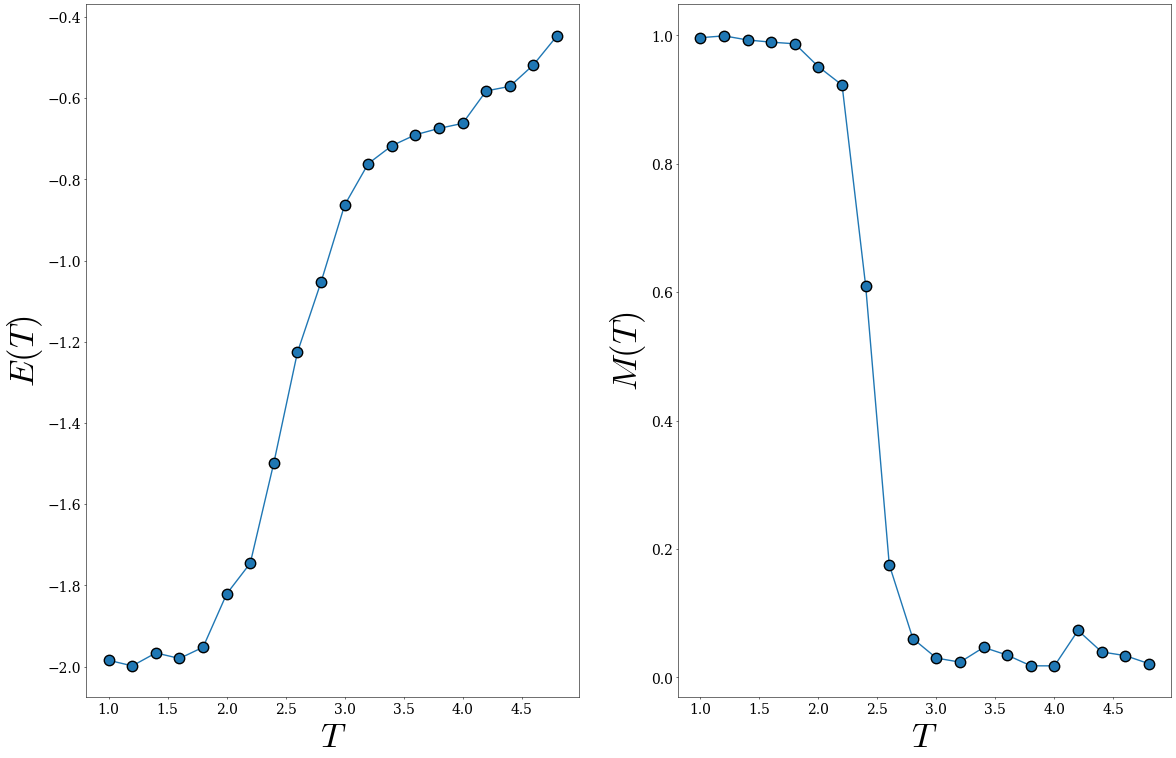

In [94]:
plt.subplot(1, 2, 1)
plt.plot(T_arr, mean_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$E(T)$')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(T_arr, mean_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$M(T)$')
plt.grid()
plt.show()

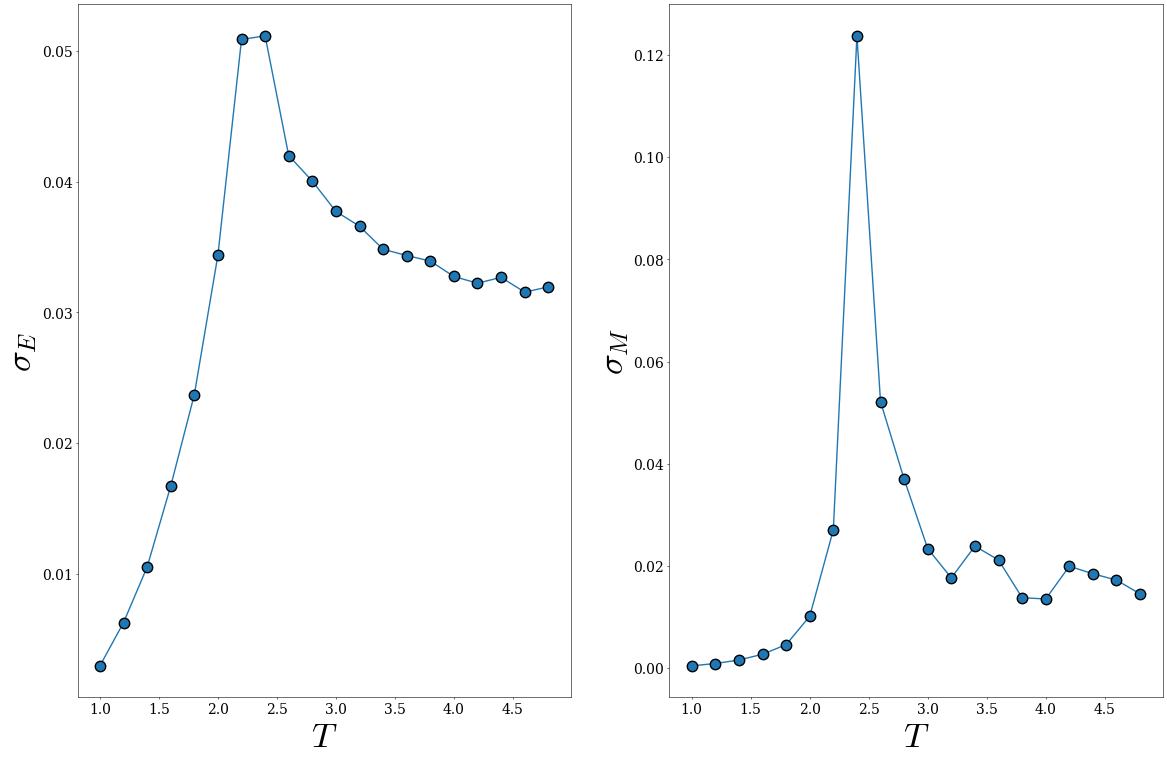

In [95]:
plt.subplot(1, 2, 1)
plt.plot(T_arr, std_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$\sigma_E$')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(T_arr, std_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\sigma_M$')
plt.grid()
plt.show()

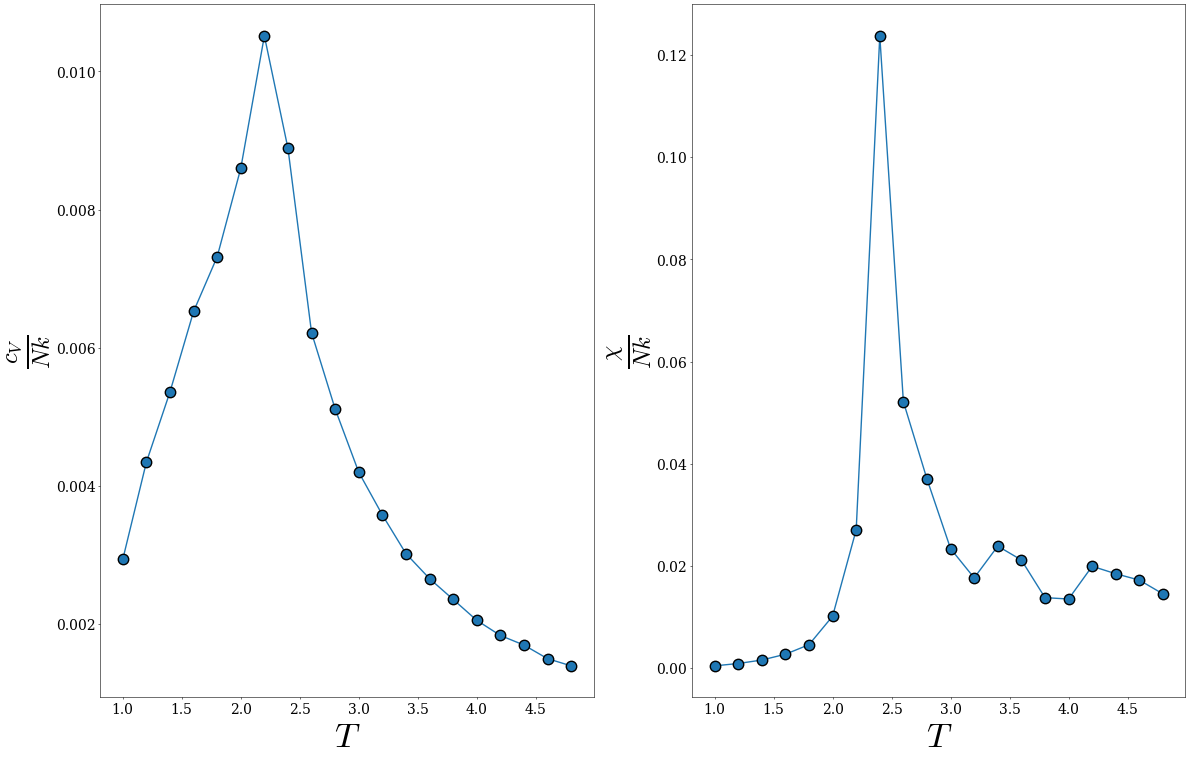

In [97]:
plt.subplot(1, 2, 1)
plt.plot(T_arr, std_E_T*(1/T_arr**2), '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{c_V}{Nk}$')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(T_arr, std_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{\chi}{Nk}$')
plt.grid()
plt.show()

# Punto 4: Correlaciones

In [23]:
@njit
def cor(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r, _ in enumerate(cor_vec):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)


@njit
def metropolis2(S: np.ndarray, prob: np.ndarray):
    # Aplica el algoritmo de Metropolis al estado S
    # if N == S.size:
    #    return S, h(S), np.mean(S)
    dm = 0
    dc = np.zeros(S.shape[0] // 2)
    for _ in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        # dE_sij = calculate_dE(opp_sij, i, j, S) - calculate_dE(
        #     sij, i, j, S
        # )
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)
        c_viejo = cor(S)  # [Optim] Levantar de cuenta anterior?
        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            dm += opp_sij
            dc += cor(S) - c_viejo  # [Optim] Se podría calcular la contribución especifica de este spin
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
    # la red, es decir, L cuadrado veces.
    # return metropolis(S, prob, N + 1)
    return S, dm / S.size, dc / S.size

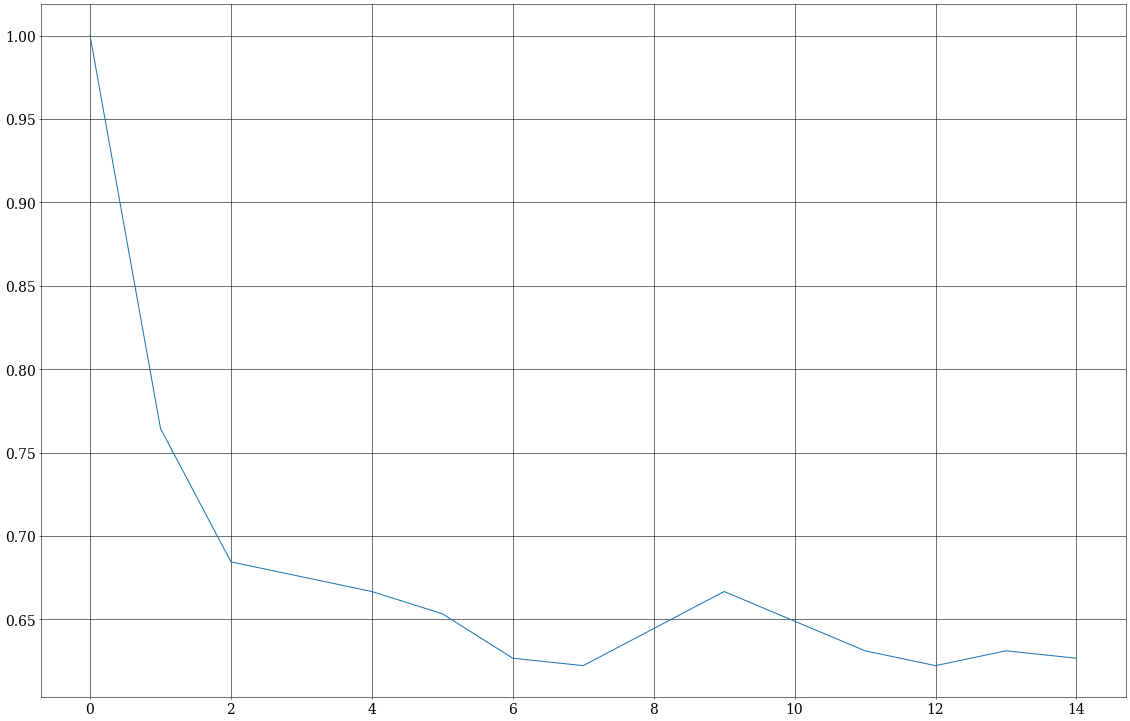

In [24]:
plt.plot(cor(S))
plt.show()

In [25]:
L = 30

nequilibrio = 1_000
npromedio = 500

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion


def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)

print("Longitud de correlacion:")

for T in tqdm([1.5, 2.3, 3], desc="Temperaturas"):

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor(S)

    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, covarianza = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print("T={} => {}".format(T, parametros[1]))

    plt.plot(r_vals, fitcor(r_vals, parametros[0], parametros[1]), label="T={}".format(T))

plt.xlabel("r")
plt.ylabel("funcion de correlacion")
plt.legend()
plt.show()

Longitud de correlacion:


Temperaturas:   0%|          | 0/3 [00:00<?, ?it/s]

Termalizando:   0%|          | 0/1000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/499 [00:00<?, ?it/s]

SystemError: CPUDispatcher(<function metropolis2 at 0x74947e726c00>) returned a result with an exception set